![Py4Eng](img/logo.png)

# Convolutional Neural Networks for Waveform Data
## Yoav Ram

In this session we will understand:
- how to open, visualize, and process audio data
- how convolutional neural networks are used to analyze and classify audio and other digital waveform signals

**Note**: We'll use the [librosa](https://librosa.github.io) package to process spectral data, please open a terminal and install it using:
```
python -m pip install librosa
```

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.signal
import scipy.io.wavfile
import glob, os, pickle
from ipywidgets import interact
from IPython.display import Audio
import pandas as pd
import tensorflow as tf
try:
    import keras
except ModuleNotFoundError:
    from tensorflow import keras
print('GPU:', tf.test.is_gpu_available())
import seaborn as sns
sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

GPU: False


# The Data

We will use the [ESC-50 dataset](https://github.com/karoldvl/ESC-50): 
> "a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.
The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class)"

Classes include, for example, Dog, Rain, Crying baby, Door knock, and Helicopter.

Start by downloading the zip file from [GitHub](https://github.com/karoldvl/ESC-50/archive/master.zip), and extracting the zip file into a `ESC-50` folder in your `data` folder.

The dataset metadata is in the `meta/esc50.csv` file:

In [2]:
audio_folder = '../data/ESC-50-master/audio/'
metadata = pd.read_csv('../data/ESC-50-master/meta/esc50.csv')
# metadata = metadata[metadata['esc10']].copy().reset_index() # select only the ESC-10 subset
metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


To load the audio files we will use [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) 

Note: you could also use `pydub`, but it requires an additional install.

In [3]:
def load_wave(i):
    fname = audio_folder + metadata['filename'][i]
    rate, wave = scipy.io.wavfile.read(fname)
    wave = (wave + 0.5) / (0x7FFF + 0.5)  # convert to float
    wave *= 1.0 / np.max(np.abs(wave)) # normalize
    return wave, rate

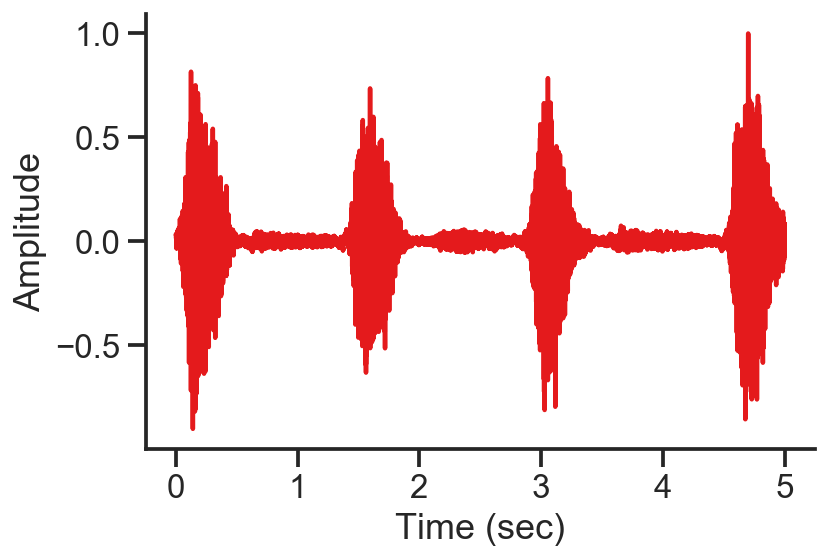

In [4]:
wave, rate = load_wave(999)
seconds = wave.size/rate
t = np.arange(0, seconds, 1/rate)
plt.plot(t, wave)
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
sns.despine()

Common practice in waveform signal analysis is to work with the [spectogram](https://en.wikipedia.org/wiki/Spectrogram) - a time series of the spectrum of frequencies of the signal.

![Spectogram](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Spectrogram-19thC.png/440px-Spectrogram-19thC.png)

Matplotlib has a function for plotting a spectrogram.

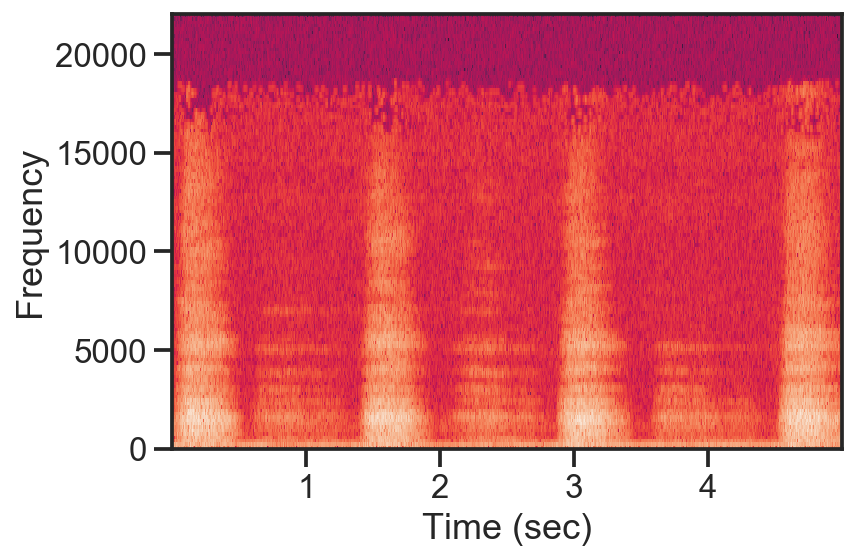

In [5]:
plt.specgram(wave, Fs=rate)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency');

The next function reads a file, plots it, and also creates an audio player using the magic of Jupyter notebooks.

In [11]:
@interact(i=(0, metadata.shape[0]-1))
def play_audio(i):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    wave, rate = load_wave(i)
    seconds = wave.size/rate
    t = np.arange(0, seconds, 1/rate)
    axes[0].plot(t, wave)
    axes[0].set(xlim=(0, seconds), xlabel='Time', ylabel='Amplitude')
    axes[1].specgram(wave, Fs=rate)
    axes[1].set(xlim=(0, seconds), xlabel='Time', ylabel='Frequency')
    sns.despine()
    fig.tight_layout()
    print(metadata['category'][i])
    return Audio(wave, rate=rate)

interactive(children=(IntSlider(value=999, description='i', max=1999), Output()), _dom_classes=('widget-intera…

# Classification with CNN

Will tackle the ESC-50 dataset with our own modified version of [Karol Piczak](https://github.com/karoldvl)'s [EchoNet](https://github.com/karoldvl/echonet) convolutional neural network for classification of environmental sounds.

![EchoNet poster](https://raw.githubusercontent.com/karoldvl/paper-2015-esc-convnet/master/Poster/MLSP2015-poster-page-1.gif)

We will be using Keras. The network and data are pretty heavy, so I used [Crestle](http://crestle.com) to run it: Crestle gives you a cloud-based Jupyter notebook with a GPU with basically ZERO configuration. First hour is free (no credit card needed, just registration), and after that it is still cheap enough to use. The network trained very fast on Crestle - but very slow on my laptop.

TensorFlows is used as the default backend (I had no luck using Theano on Crestle anyway).
TensorFlow's `device_lib.list_local_devices()` function allows you to see which "devices" (i.e. processors) will be used, so on the laptop there's just CPU, but on Crestle there is a GPU.

## Prepare data

Following EchoNet, we use a different type of spectrogram from the one offered by SciPy, a [melspectrogram](http://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html), which is implemented in the [librosa](https://librosa.github.io) package (`pip install librosa`). The exact settings as well as the log-amplitude transform (conversion to decibel units) are also following EchoNet.

In [14]:
import librosa

def load_spectogram(i):    
    wave, rate = load_wave(i)
    spec = librosa.feature.melspectrogram(wave, sr=rate, n_fft=1024,
                                          hop_length=512, n_mels=60)
    spec = librosa.amplitude_to_db(spec)    
    return spec

All our audio clips are five seconds long, but we don't have many of them.
We are going to segment them to ~1 second long overlapping clips to augment the data.

In [15]:
def segement_spectogram(spec, segment_length=101, hop_length=20):
    offset = 0
    segments = []
    while offset < spec.shape[1] - segment_length:
        segment = spec[:, offset:offset+segment_length]
        offset += hop_length
        segments.append(segment)
    return segments

In [16]:
spec = load_spectogram(999)
segments = segement_spectogram(spec)
print(len(segments))

17


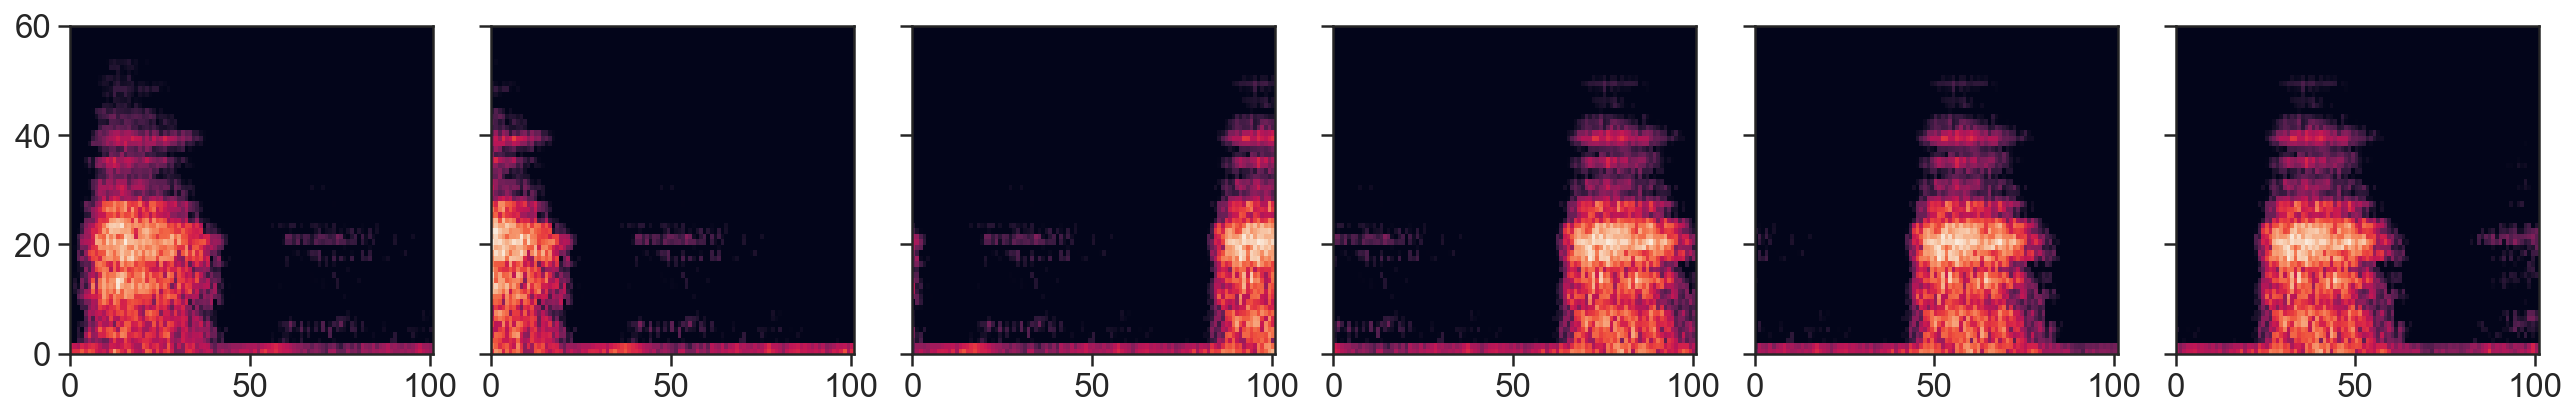

In [17]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3), sharex=True, sharey=True)
for seg, ax in zip(segments, axes):
    ax.pcolormesh(seg)
fig.tight_layout()

Let's load the spectogram of all files and then segment all of them.

In [18]:
X = np.array([segement_spectogram(load_spectogram(i)) for i in range(0, metadata.shape[0])])
X = X.reshape((-1, *X.shape[2:]))

We are also going to add (using [librosa](https://github.com/librosa/librosa) again) a derivative feature called $\Delta$ (_delta_): local estimate of the derivative of the spectogram along the time axis.

/Users/yoavram/miniconda3/envs/DataSciPy/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


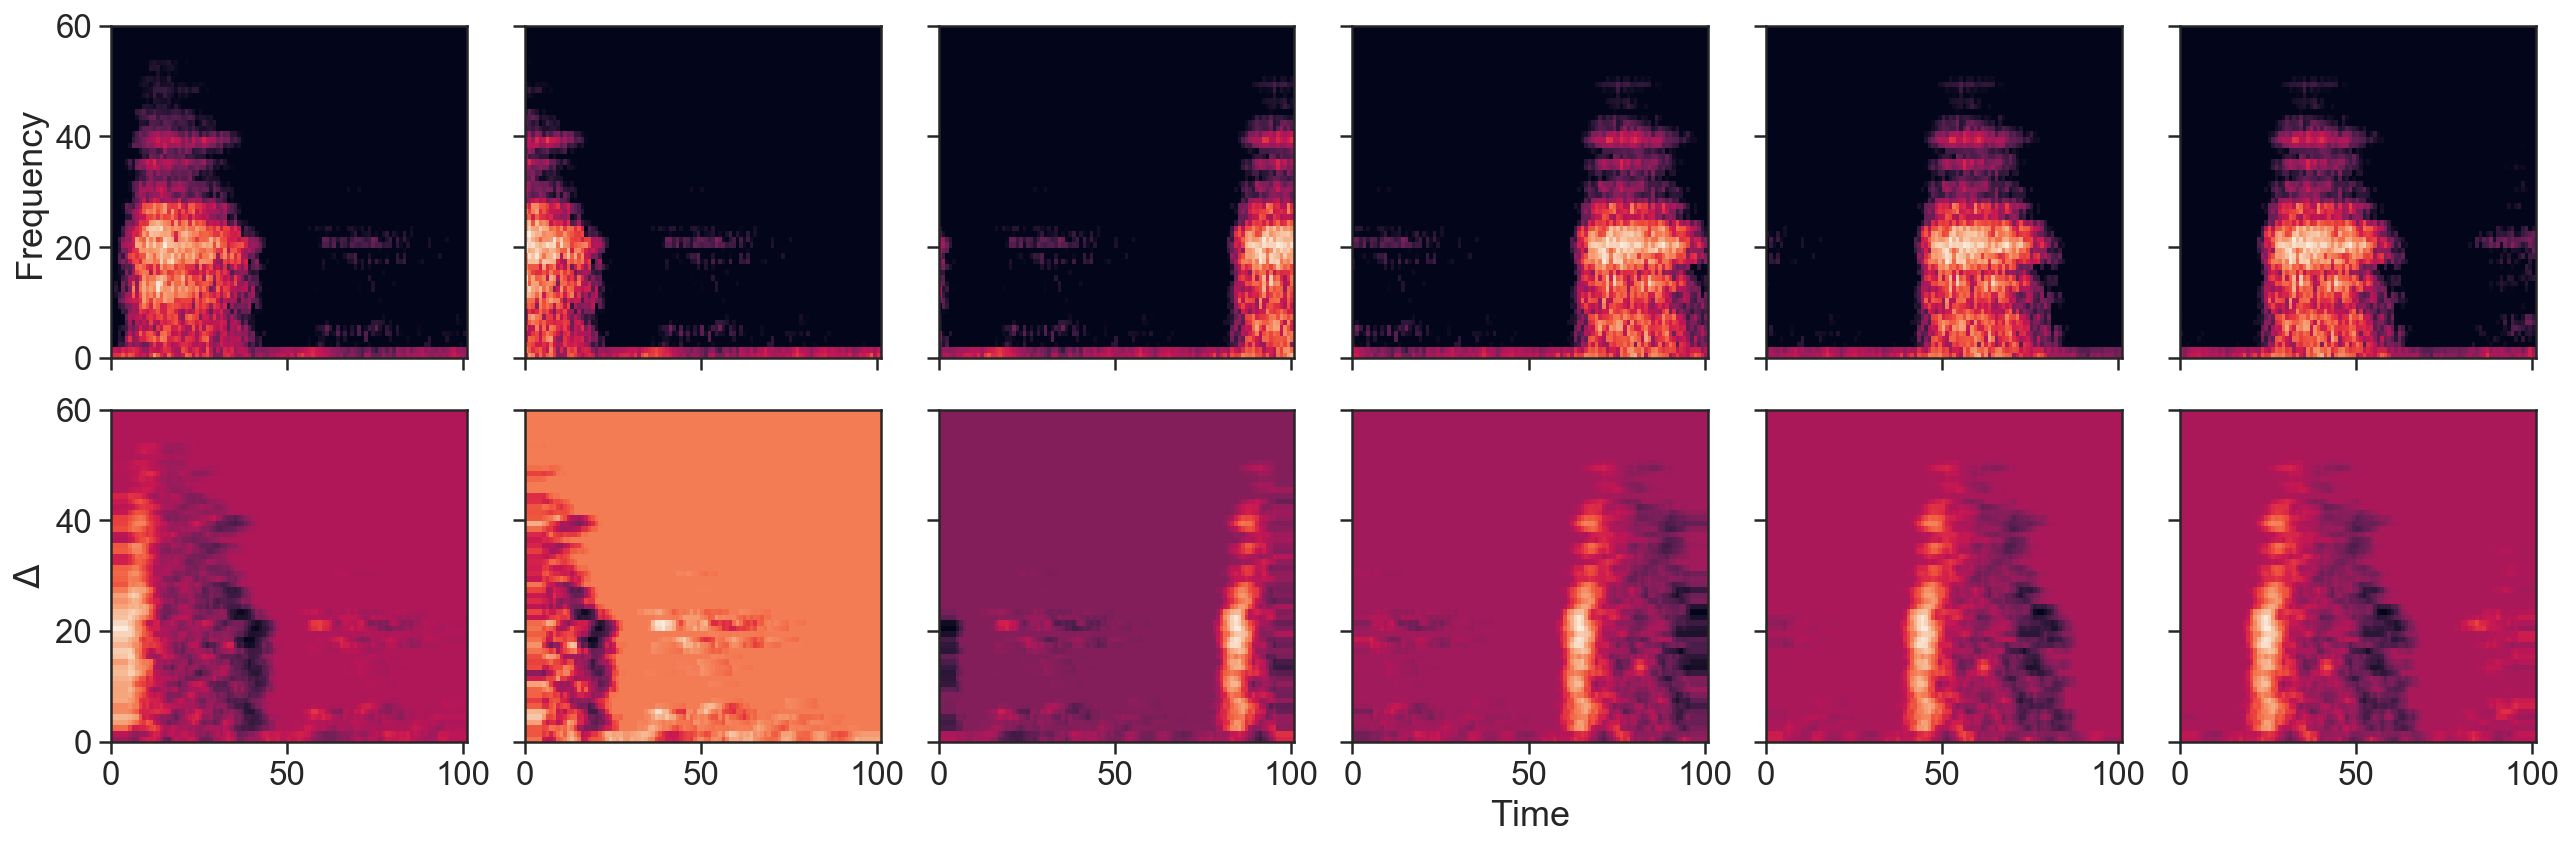

In [19]:
fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharex=True, sharey=True)
for i in range(6):
    seg = segments[i]
    axes[0,i].pcolormesh(seg)
    axes[1,i].pcolormesh(librosa.feature.delta(seg))
axes[0,0].set_ylabel('Frequency')
axes[1,0].set_ylabel(r'$\Delta$')
axes[1, 3].set_xlabel('Time')
fig.tight_layout()

We calculate the $\Delta$ for all the segments and add it as a seconds "channel" (new dimension or axis; similar to how color images have 3 channels).

In [20]:
deltas = np.array([librosa.feature.delta(seg) for i, seg in enumerate(X)])
X = np.stack((X, deltas), axis=-1)

Now we normalize the data:

In [21]:
X -= X.mean()
X /= X.std()

The y values (truth, labels, targets)  are extracted from the metadata and repeated so that each segment has the label of the clip it is part of.
We also one-hot encode it with `keras.utils.to_categorical`.

In [22]:
Y = metadata['target'].values

num_repeats = X.shape[0]//Y.shape[0]
Y = np.repeat(Y, num_repeats)

Y = keras.utils.to_categorical(Y)

assert X.shape[0] == Y.shape[0]

## Build network

Now to build the model. The poster above specifies the networks, but it is a pretty standard CNN.
The interesting parts are that the convolution kernels are not symmetric (i.e. not 5x5) but that makes sense because the axes are not width and height but rather time and frequency (or derivative of frequnecy).
Same for the pooling. See the [paper](https://github.com/karoldvl/paper-2015-esc-convnet) for details.

In [23]:
input_shape = X.shape
class_count = Y.shape[1]
L2 = keras.regularizers.l2
uniform = keras.initializers.RandomUniform
normal = keras.initializers.RandomNormal

layers = [
    keras.layers.Conv2D(80, (57, 6),  kernel_initializer=uniform(-0.001, 0.001), kernel_regularizer=L2(0.001), input_shape=X.shape[1:]),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D((4, 3), (1, 3)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(80, (1, 3), kernel_initializer=uniform(-0.1, 0.1), kernel_regularizer=L2(0.001)),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D((1, 3), (1, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(5000, kernel_initializer=normal(0, 0.01), kernel_regularizer=L2(0.001)),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1000, kernel_initializer=normal(0, 0.01), kernel_regularizer=L2(0.001)),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(class_count, kernel_initializer=normal(0.01), kernel_regularizer=L2(0.001)),
    keras.layers.Activation('softmax')
]
model = keras.models.Sequential(layers)

In [24]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)

## Train

Now we can train the model. We work on batches of 1000 segments per batch, with 150 epochs (one epoch is a pass on all the dataset) and a validation split of 10% (i.e. the test set is 10% of the dataset).

This takes some time to run on a CPU, but only about 2 secs per epoch for about 5 minutes on a GPU.

In [16]:
history = model.fit(X, Y, shuffle=True, batch_size=1000, epochs=150, 
                    validation_split=0.1, verbose=1).history

Train on 10800 samples, validate on 1200 samples
Epoch 1/150
10800/10800 [==============================] - 114s 11ms/step - loss: 4.1665 - acc: 0.0219 - val_loss: 4.0972 - val_acc: 0.0100
Epoch 2/150
10800/10800 [==============================] - 2s 173us/step - loss: 4.0765 - acc: 0.0274 - val_loss: 4.0199 - val_acc: 0.0475
Epoch 3/150
10800/10800 [==============================] - 2s 173us/step - loss: 4.0375 - acc: 0.0493 - val_loss: 3.9966 - val_acc: 0.0392
Epoch 4/150
10800/10800 [==============================] - 2s 171us/step - loss: 4.0089 - acc: 0.0603 - val_loss: 3.9778 - val_acc: 0.0492
Epoch 5/150
10800/10800 [==============================] - 2s 169us/step - loss: 3.9621 - acc: 0.0640 - val_loss: 3.9446 - val_acc: 0.0292
Epoch 6/150
10800/10800 [==============================] - 2s 170us/step - loss: 3.8448 - acc: 0.0777 - val_loss: 3.8364 - val_acc: 0.0808
Epoch 7/150
10800/10800 [==============================] - 2s 170us/step - loss: 3.6663 - acc: 0.1048 - val_loss: 3.

In [17]:
model.save('../data/keras_esc50_model.h5')
with open("../data/keras_esc50_history.p", "wb") as f:
    pickle.dump(history, f)

Load pre-saved model and history:

In [118]:
model = keras.models.load_model('../data/keras_esc50_model.h5')
with open("../data/keras_esc50_history.p", "rb") as f:
    history= pickle.load(f)

Plots evolution of the model accuracy and loss on the train and test data:

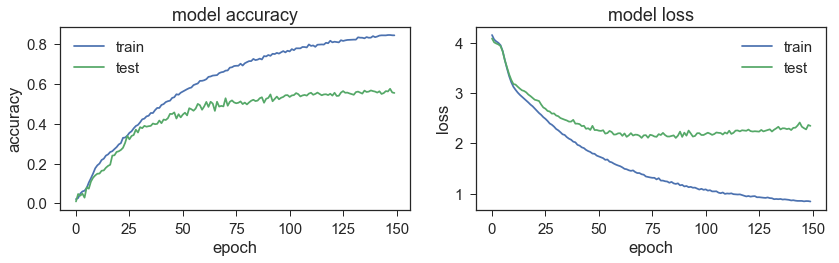

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

ax = axes[0]
ax.plot(history['acc'], label='train')
ax.plot(history['val_acc'], label='test')
ax.set(
    title='model accuracy',
    ylabel='accuracy',
    xlabel='epoch',
)
ax.legend()

ax = axes[1]
ax.plot(history['loss'], label='train')
ax.plot(history['val_loss'], label='test')
ax.set(
    title='model loss',
    ylabel='loss',
    xlabel='epoch',
)
ax.legend()
    
fig.tight_layout()

Looks like we could run the training for a bit longer as the test accuract didn't neccessarily converge.
Anyway, we reached about 55% accuracy on a 50 category task. 

The [ESC-50 Github page](https://github.com/karoldvl/ESC-50) has a comparison table for many models that were trained on the ESC-50 task. 

The best one reached 86% accuracy using "CNN with filterbanks learned using convolutional RBM + fusion with GTSC and mel energies". 

Our accuracy is, according to the table, the median accuracy, but EchoNet reaches 64% based on the table.

Also, human accuracy is 81%.

Some of the best techniques seem to use _transfer learning_, in which a image model that was pre-trained on image classification (e.g. on ImageNet) predicts labels for millions of videos, and those predictions are used, together with the videos sound, to train an audio model.

## Predict 
How do we make predictions? We need to input segments rather than a full clip, but if we have a full clip we can segment it, predict on each segment, and average the results.

In [122]:
def predict(i):
    x = load_spectogram(i)
    x = np.array(segement_spectogram(x))
    x = np.stack((x, librosa.feature.delta(x)), axis=-1)
    predictions = model.predict(x)
    predictions = predictions.mean(axis=0)
    pred_target = predictions.argmax()
    pred_category = metadata[metadata['target'] == pred_target]['category'].unique()[0]
    return pred_category, predictions.max()

Prediction: fireworks (58.81%%)
fireworks


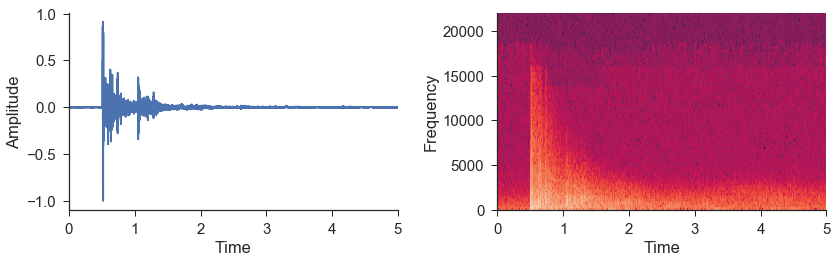

In [133]:
i = 19
print("Prediction: {} ({:.2%}%)".format(*predict(i)))
play_audio(i)

# Exercise

Open the [audio exercise](../exercises/audio.ipynb) to predict emotions in speech; this would be an easier problem, but you will need to make some changes as it is a regression rather than classification task and the dataset is smaller.

# References

- [EchoNet](https://github.com/karoldvl/echonet) - the network above roughly follows this model
- [SoundNet](https://projects.csail.mit.edu/soundnet/) - another interesting example of neural nets for sound classification
- [WaveNet](https://deepmind.com/blog/wavenet-generative-model-raw-audio/) - generative model for speech
- [Whale Detection Challenge](https://www.kaggle.com/c/whale-detection-challenge) on Kaggle - create an algorithm to detect North Atlantic right whale calls from audio recordings, prevent collisions with shipping traffic

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.

This work is licensed under a [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)